In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Supply Chain Efficiency KPIs:
On-Time Delivery Rate: 76.27%
Average Delivery Time: 1.89 days
Average Lead Time: 1.89 days
Lead Time Efficiency: 113782.01%

Supply Chain Risk Indicators (KRIs):
Late Delivery Percentage: 23.73%
Extreme Delay Percentage: 2.67%
High Risk Orders: 14.93%
Procurement Delay Percentage: 96.00%

Category-Specific On-Time Delivery Rates:
Camera: 75.37%
CameraAccessory: 75.79%
EntertainmentSmall: 77.75%
GameCDDVD: 74.47%
GamingHardware: 69.47%


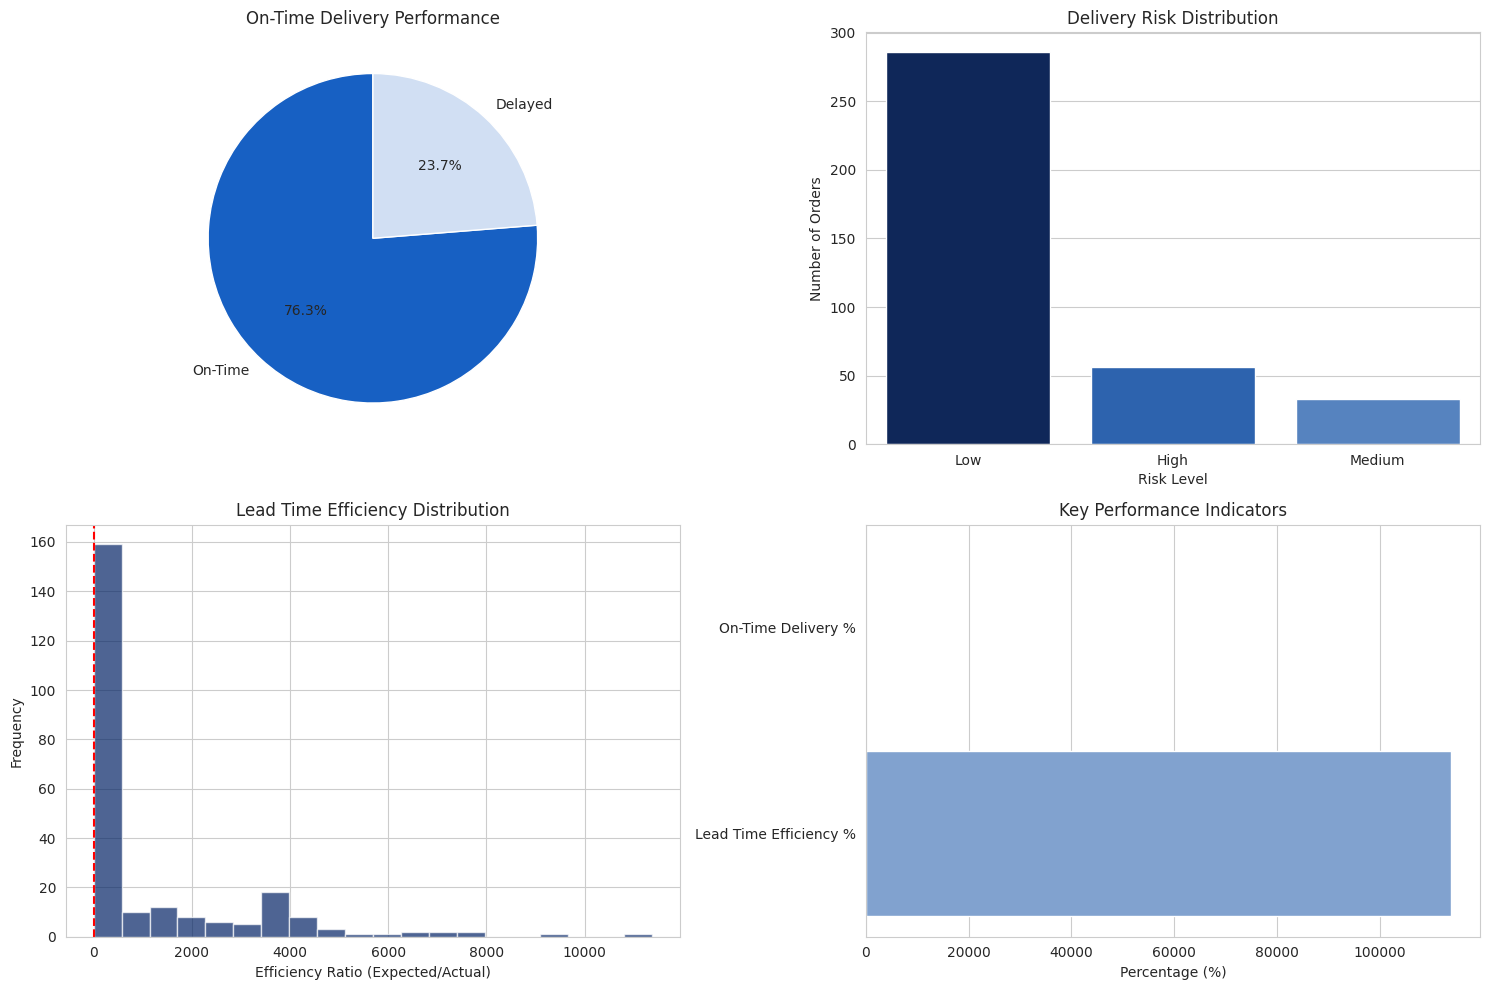

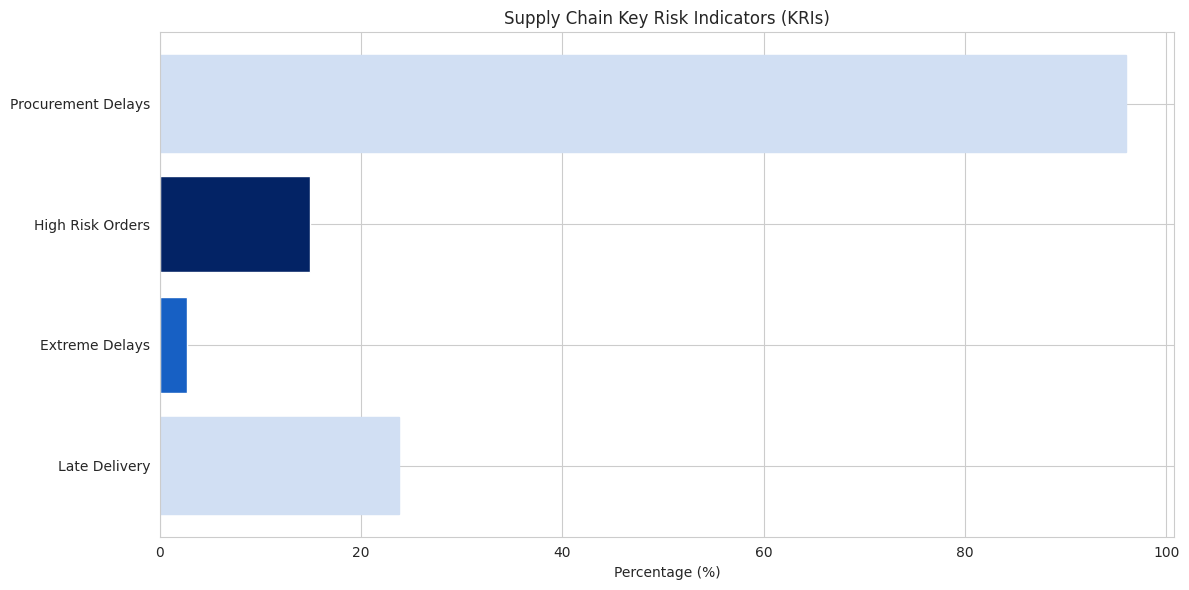

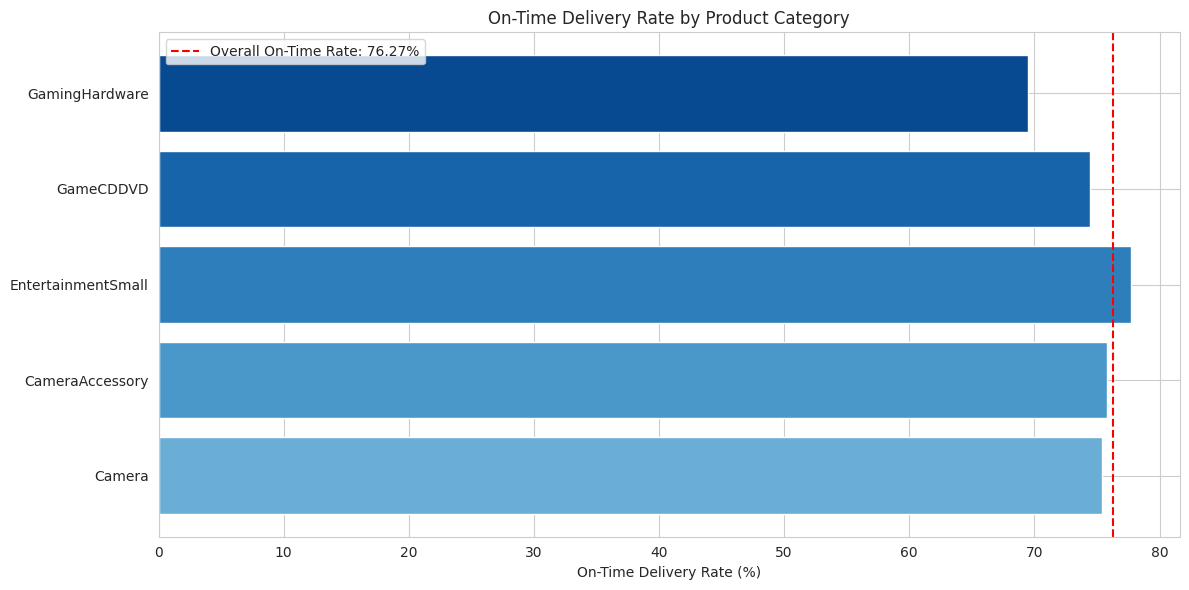

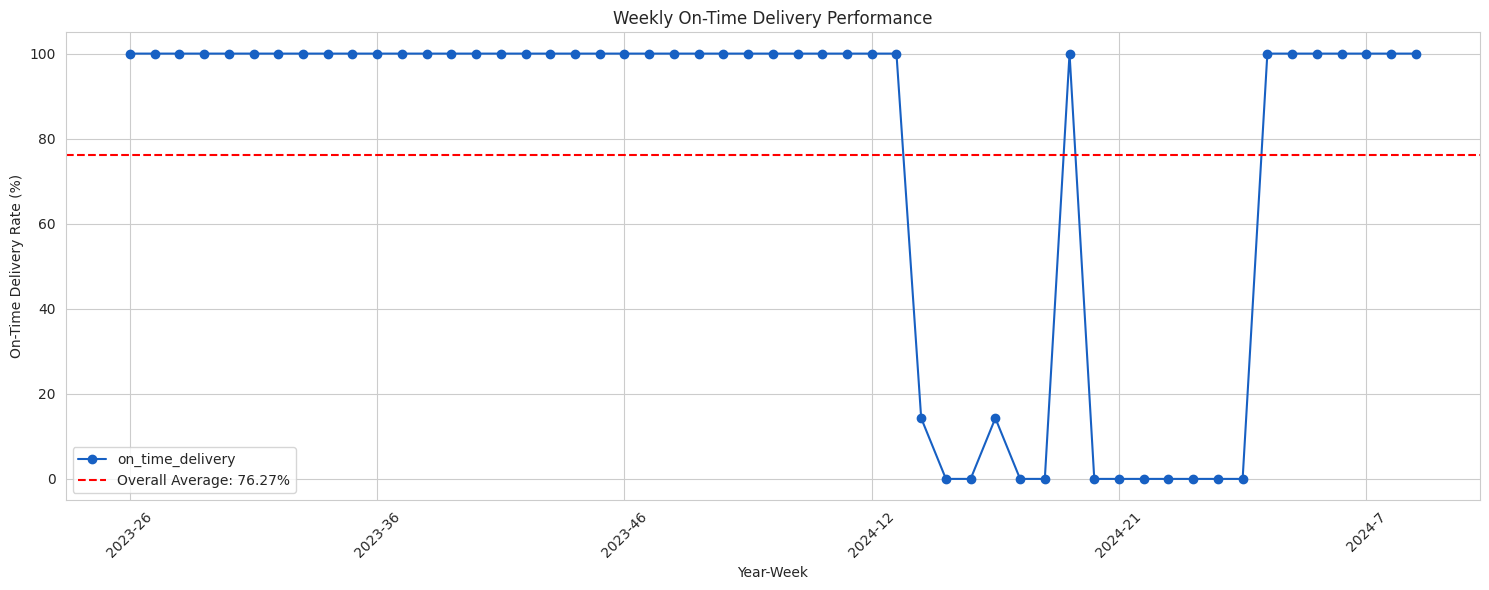

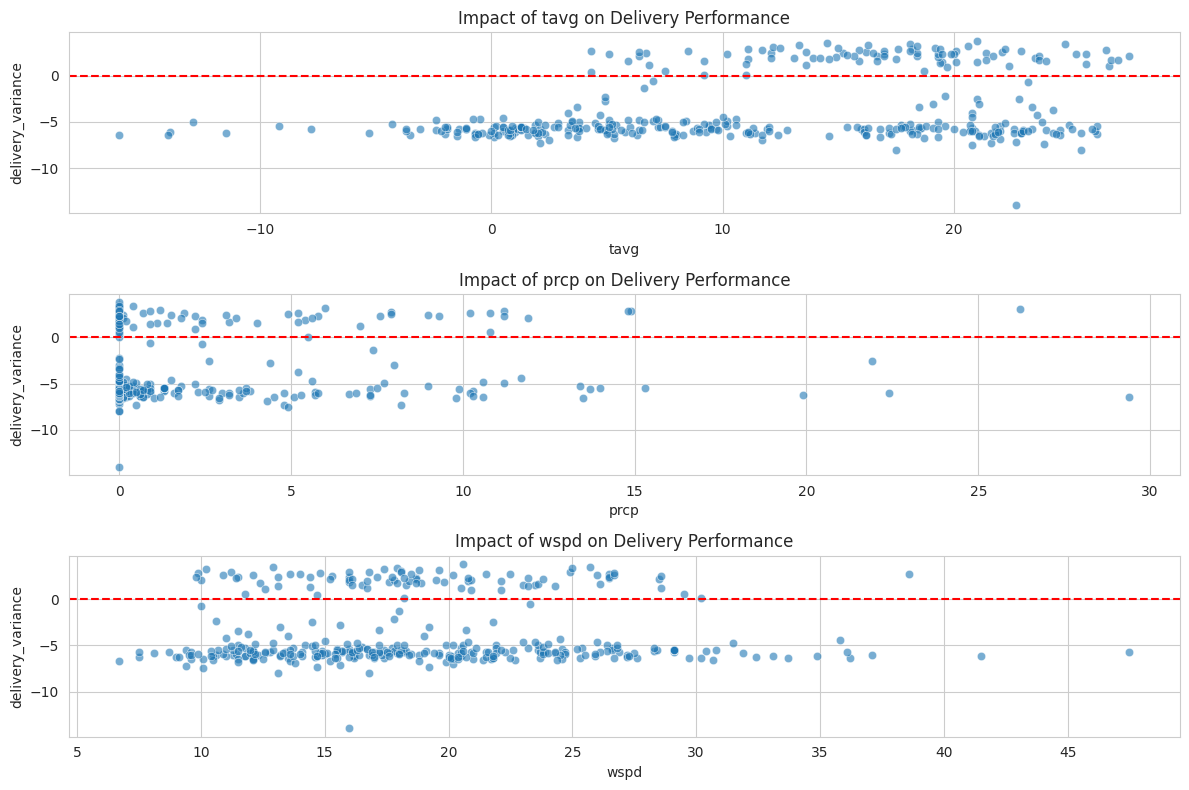

In [10]:
def calculate_supply_chain_efficiency(data):
    """
    Calculate supply chain efficiency metrics using delivery times and SLAs

    Parameters:
    data (DataFrame): DataFrame containing order data with deliverybdays, deliverycdays,
                     sla, and product_procurement_sla

    Returns:
    DataFrame: Original data with additional efficiency metrics
    dict: Summary of KRIs and KPIs
    """
    df = data.copy()

    # Replace N values with 0 as mentioned in the case
    df['deliverybdays'] = df['deliverybdays'].replace('N', 0).astype(float)
    df['deliverycdays'] = df['deliverycdays'].replace('N', 0).astype(float)

    # Calculate efficiency metrics

    # 1. Delivery Performance
    df['actual_delivery_time'] = df['deliverybdays'] + df['deliverycdays']
    df['delivery_variance'] = df['actual_delivery_time'] - df['sla']  # Note lowercase 'sla'
    df['on_time_delivery'] = np.where(df['delivery_variance'] <= 0, 1, 0)

    # 2. Procurement Performance
    # Prevent division by zero
    df['procurement_efficiency'] = np.where(
        df['product_procurement_sla'] > 0.001,
        df['deliverybdays'] / df['product_procurement_sla'],
        np.nan
    )

    # 3. Overall Supply Chain Efficiency
    df['total_lead_time'] = df['deliverybdays'] + df['deliverycdays']
    df['expected_lead_time'] = df['sla'] + df['product_procurement_sla']

    # Prevent division by zero
    df['lead_time_efficiency'] = np.where(
        df['total_lead_time'] > 0.001,
        df['expected_lead_time'] / df['total_lead_time'],
        np.nan
    )

    # 4. Risk Indicators
    df['delivery_risk'] = np.select(
        [df['delivery_variance'] <= -2, df['delivery_variance'] <= 0, df['delivery_variance'] <= 2, df['delivery_variance'] > 2],
        ['Low', 'Low', 'Medium', 'High'],
        default='High'
    )

    df['procurement_risk'] = np.select(
        [df['procurement_efficiency'] < 0.8, df['procurement_efficiency'] <= 1.2, df['procurement_efficiency'] > 1.2],
        ['High', 'Low', 'Medium'],
        default='Medium'
    )

    # 5. Product Category-Specific Supply Chain Metrics
    product_categories = ['Camera', 'CameraAccessory', 'EntertainmentSmall', 'GameCDDVD', 'GamingHardware']

    for category in product_categories:
        # Calculate category-specific delivery performance if GMV column exists
        if f'{category}_gmv' in df.columns:
            df[f'{category}_delivery_performance'] = df['on_time_delivery'] * df[f'{category}_gmv']

            # Calculate category-specific risk score (higher = more risky)
            risk_score_map = {'Low': 1, 'Medium': 2, 'High': 3}
            df[f'{category}_risk_score'] = df['delivery_risk'].map(risk_score_map)

            # Calculate weighted risk impact by GMV
            df[f'{category}_risk_impact'] = df[f'{category}_risk_score'] * df[f'{category}_gmv']

            # Analyze relationship between discounts and delivery performance
            if f'{category}_discount' in df.columns:
                df[f'{category}_discount_delivery_relation'] = df[f'{category}_discount'] * df['on_time_delivery']

    # 6. External Factors Impact on Supply Chain
    # Holiday impact on delivery
    if 'holidays' in df.columns:
        df['holiday_delivery_impact'] = df['holidays'] * df['delivery_variance']

    # Weather impact on delivery
    weather_cols = ['tavg', 'prcp', 'wspd']
    for col in weather_cols:
        if col in df.columns:
            df[f'{col}_delivery_impact'] = df[col] * df['delivery_variance']

    # 7. Calculate weekly supply chain performance trends
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df['week'] = df['date'].dt.isocalendar().week
        df['year'] = df['date'].dt.isocalendar().year

        # Create a year-week column for easy grouping
        df['year_week'] = df['year'].astype(str) + '-' + df['week'].astype(str)

    # Calculate KPIs and KRIs
    kpi_kri = {
        # KPIs
        'on_time_delivery_rate': df['on_time_delivery'].mean() * 100,
        'average_delivery_time': df['actual_delivery_time'].mean(),
        'average_lead_time': df['total_lead_time'].mean(),
        'lead_time_efficiency': df['lead_time_efficiency'].mean() * 100,

        # KRIs
        'late_delivery_percentage': (1 - df['on_time_delivery'].mean()) * 100,
        'extreme_delay_percentage': (df['delivery_variance'] > 3).mean() * 100,
        'high_risk_orders_percentage': (df['delivery_risk'] == 'High').mean() * 100,
        'procurement_delay_percentage': (df['procurement_risk'] == 'High').mean() * 100
    }

    # Add category-specific KPIs
    for category in product_categories:
        if f'{category}_gmv' in df.columns and df[f'{category}_gmv'].sum() > 0:
            # Calculate category on-time delivery rate weighted by GMV
            kpi_kri[f'{category}_on_time_rate'] = (
                df[f'{category}_delivery_performance'].sum() / df[f'{category}_gmv'].sum() * 100
            )

            # Calculate category risk impact
            if f'{category}_risk_impact' in df.columns:
                kpi_kri[f'{category}_risk_impact'] = df[f'{category}_risk_impact'].sum() / df[f'{category}_gmv'].sum()

    return df, kpi_kri

def visualize_supply_chain_efficiency(df, kpi_kri):
    """
    Create visualizations for supply chain efficiency metrics

    Parameters:
    df (DataFrame): DataFrame with calculated efficiency metrics
    kpi_kri (dict): Dictionary containing KPI and KRI summary
    """
    # Set up the visualization style
    sns.set_style('whitegrid')
    plt.figure(figsize=(15, 10))

    # 1. On-Time Delivery Performance
    plt.subplot(2, 2, 1)
    labels = ['On-Time', 'Delayed']
    sizes = [kpi_kri['on_time_delivery_rate'], kpi_kri['late_delivery_percentage']]
    colors = ['#1760c3', '#d1dff3']
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('On-Time Delivery Performance')

    # 2. Delivery Risk Distribution
    plt.subplot(2, 2, 2)
    risk_counts = df['delivery_risk'].value_counts()
    # Updated to use hue instead of just palette
    sns.barplot(x=risk_counts.index, y=risk_counts.values, hue=risk_counts.index,
                palette=['#032365', '#1760C4', '#4580d0'], legend=False)
    plt.title('Delivery Risk Distribution')
    plt.xlabel('Risk Level')
    plt.ylabel('Number of Orders')

    # 3. Lead Time Efficiency
    plt.subplot(2, 2, 3)
    # Filter out non-finite values before plotting histogram
    finite_efficiency = df['lead_time_efficiency'][np.isfinite(df['lead_time_efficiency'])]
    plt.hist(finite_efficiency, bins=20, color='#032365', alpha=0.7)
    plt.axvline(x=1, color='red', linestyle='--')
    plt.title('Lead Time Efficiency Distribution')
    plt.xlabel('Efficiency Ratio (Expected/Actual)')
    plt.ylabel('Frequency')

    # 4. KPI Dashboard
    plt.subplot(2, 2, 4)
    kpis = ['on_time_delivery_rate', 'lead_time_efficiency']
    values = [kpi_kri[kpi] for kpi in kpis]
    # Updated to use hue
    sns.barplot(x=values, y=['On-Time Delivery %', 'Lead Time Efficiency %'],
                hue=['On-Time Delivery %', 'Lead Time Efficiency %'],
                palette=['#032365', '#74a0dc'], legend=False)
    plt.title('Key Performance Indicators')
    plt.xlabel('Percentage (%)')

    plt.tight_layout()
    plt.show()

    # Create a KRI dashboard
    plt.figure(figsize=(12, 6))
    kris = ['late_delivery_percentage', 'extreme_delay_percentage',
            'high_risk_orders_percentage', 'procurement_delay_percentage']
    kri_names = ['Late Delivery', 'Extreme Delays', 'High Risk Orders', 'Procurement Delays']
    kri_values = [kpi_kri[kri] for kri in kris]

    # Define thresholds for risk indicators
    thresholds = [15, 10, 20, 15]

    # Create horizontal bar chart for KRIs
    bars = plt.barh(kri_names, kri_values, color=['#032365', '#1760c4', '#032365', '#74a0dc'])

    # Color code bars based on threshold
    for i, (bar, threshold) in enumerate(zip(bars, thresholds)):
        if kri_values[i] > threshold:
            bar.set_color('#d1dff3')

    plt.title('Supply Chain Key Risk Indicators (KRIs)')
    plt.xlabel('Percentage (%)')
    plt.tight_layout()
    plt.show()

    # New visualization: Product Category Supply Chain Performance
    product_categories = ['Camera', 'CameraAccessory', 'EntertainmentSmall', 'GameCDDVD', 'GamingHardware']
    category_kpis = [f'{cat}_on_time_rate' for cat in product_categories if f'{cat}_on_time_rate' in kpi_kri]

    if category_kpis:
        plt.figure(figsize=(12, 6))
        category_names = [cat.split('_')[0] for cat in category_kpis]
        category_values = [kpi_kri[kpi] for kpi in category_kpis]

        # Use hue parameter in barplot
        bar_colors = plt.cm.Blues([0.5 + 0.1*i for i in range(len(category_names))])
        plt.barh(category_names, category_values, color=bar_colors)
        plt.axvline(x=kpi_kri['on_time_delivery_rate'], color='red', linestyle='--',
                   label=f'Overall On-Time Rate: {kpi_kri["on_time_delivery_rate"]:.2f}%')
        plt.title('On-Time Delivery Rate by Product Category')
        plt.xlabel('On-Time Delivery Rate (%)')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Weekly trend analysis if date has been converted and week column exists
    if 'year_week' in df.columns:
        # Calculate weekly on-time delivery rate
        weekly_data = df.groupby('year_week')
        weekly_perf = weekly_data['on_time_delivery'].mean() * 100

        # Only plot if we have sufficient data
        if len(weekly_perf) > 1:
            plt.figure(figsize=(15, 6))
            weekly_perf.plot(kind='line', marker='o', color='#1760c3')
            plt.axhline(y=kpi_kri['on_time_delivery_rate'], color='red', linestyle='--',
                       label=f'Overall Average: {kpi_kri["on_time_delivery_rate"]:.2f}%')
            plt.title('Weekly On-Time Delivery Performance')
            plt.xlabel('Year-Week')
            plt.ylabel('On-Time Delivery Rate (%)')
            plt.xticks(rotation=45)
            plt.legend()
            plt.tight_layout()
            plt.show()

    # Optional: Supply Chain vs Weather correlation visualization
    weather_cols = ['tavg', 'prcp', 'wspd']
    weather_impacts = [col for col in df.columns if col.endswith('_delivery_impact') and col.split('_')[0] in weather_cols]

    if weather_impacts and all(np.isfinite(df[impact]).any() for impact in weather_impacts):
        plt.figure(figsize=(12, 8))

        for i, impact in enumerate(weather_impacts):
            weather_var = impact.split('_')[0]
            plt.subplot(len(weather_impacts), 1, i+1)

            # Use scatterplot for visualization
            valid_data = df[[weather_var, 'delivery_variance']][np.isfinite(df[weather_var]) & np.isfinite(df['delivery_variance'])]
            if len(valid_data) > 0:
                sns.scatterplot(x=weather_var, y='delivery_variance', data=valid_data, alpha=0.6)
                plt.title(f'Impact of {weather_var} on Delivery Performance')
                plt.axhline(y=0, color='red', linestyle='--')

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    df = pd.read_csv('daily_final(probably).csv')

    efficiency_df, kpi_kri_results = calculate_supply_chain_efficiency(df)

    print("Supply Chain Efficiency KPIs:")
    print(f"On-Time Delivery Rate: {kpi_kri_results['on_time_delivery_rate']:.2f}%")
    print(f"Average Delivery Time: {kpi_kri_results['average_delivery_time']:.2f} days")
    print(f"Average Lead Time: {kpi_kri_results['average_lead_time']:.2f} days")
    print(f"Lead Time Efficiency: {kpi_kri_results['lead_time_efficiency']:.2f}%")

    print("\nSupply Chain Risk Indicators (KRIs):")
    print(f"Late Delivery Percentage: {kpi_kri_results['late_delivery_percentage']:.2f}%")
    print(f"Extreme Delay Percentage: {kpi_kri_results['extreme_delay_percentage']:.2f}%")
    print(f"High Risk Orders: {kpi_kri_results['high_risk_orders_percentage']:.2f}%")
    print(f"Procurement Delay Percentage: {kpi_kri_results['procurement_delay_percentage']:.2f}%")

    product_categories = ['Camera', 'CameraAccessory', 'EntertainmentSmall', 'GameCDDVD', 'GamingHardware']
    print("\nCategory-Specific On-Time Delivery Rates:")
    for category in product_categories:
        if f'{category}_on_time_rate' in kpi_kri_results:
            print(f"{category}: {kpi_kri_results[f'{category}_on_time_rate']:.2f}%")

    visualize_supply_chain_efficiency(efficiency_df, kpi_kri_results)